In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import functools
import math
import random

import GPUtil
import IPython.display as ipd
import matplotlib.pyplot as plt
import torch
import torchutil

import ppgs
import promonet

In [54]:
# Configuration name
promonet.CONFIG = 'w2v2fb'

# Whether to perform speaker adaptation (instead of multi-speaker)
promonet.ADAPTATION = False

# Batch size
promonet.BATCH_SIZE = 32

# Number of samples generated during training
promonet.CHUNK_SIZE = 8192

# Evaluation ratios for pitch-shifting, time-stretching, and loudness-scaling
promonet.EVALUATION_RATIOS = [.891, 1.12]

# Input features
promonet.INPUT_FEATURES = ['pitch', 'ppg']

# The model to use. One of ['hifigan', 'psola', 'vits', 'vocos', 'world'].
promonet.MODEL = 'vits'

# Number of training steps
promonet.STEPS = 250000

In [55]:
# Number of input features to the generator
promonet.NUM_FEATURES = promonet.NUM_MELS if promonet.SPECTROGRAM_ONLY else (
    promonet.PPG_CHANNELS +
    ('loudness' in promonet.INPUT_FEATURES) +
    ('periodicity' in promonet.INPUT_FEATURES) +
    ('pitch' in promonet.INPUT_FEATURES) * (
        promonet.PITCH_EMBEDDING_SIZE if promonet.PITCH_EMBEDDING else 1))

# Number of input features to the discriminator
promonet.NUM_FEATURES_DISCRIM = (
    1 +
    promonet.CONDITION_DISCRIM +
    promonet.CONDITION_DISCRIM +
    promonet.CONDITION_DISCRIM +
    promonet.CONDITION_DISCRIM * promonet.PPG_CHANNELS)

# Location to save dataset partitions
promonet.PARTITION_DIR = (
    promonet.ASSETS_DIR /
    'partitions' /
    ('adaptation' if promonet.ADAPTATION else 'multispeaker'))

## Test PPG representation

In [46]:
dataset = 'vctk'
stems = promonet.load.partition(dataset)['train']

In [47]:
stem = random.choice(stems)

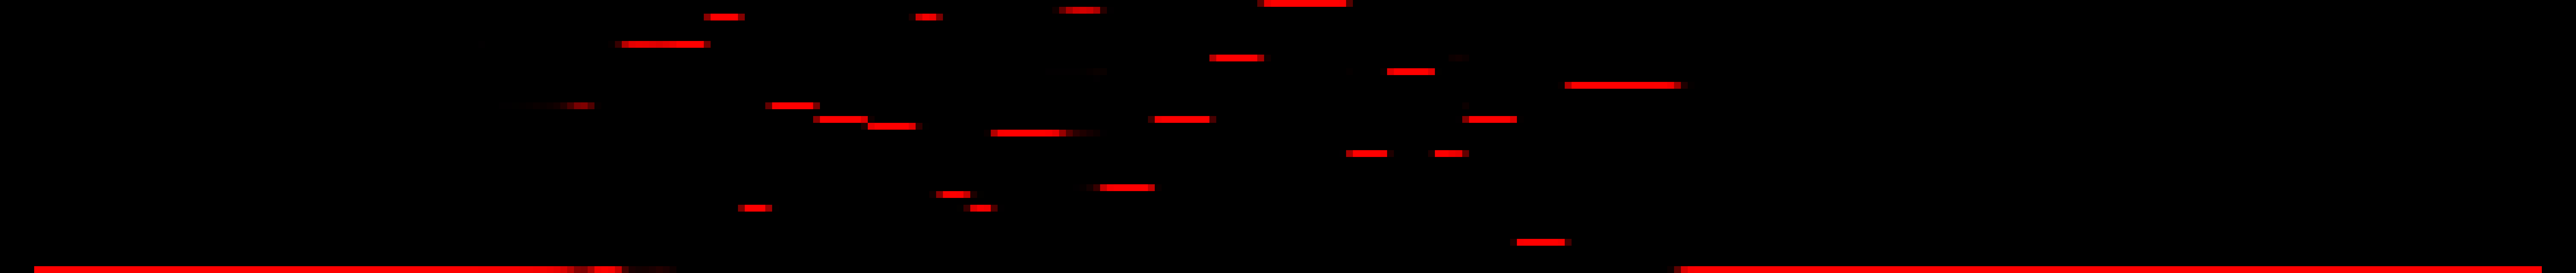

In [48]:
ppgs.plot.from_ppg_file_to_file(
    promonet.CACHE_DIR / dataset / f'{stem}-100-ppg.pt',
    'ppg.png')
ipd.Image('ppg.png')

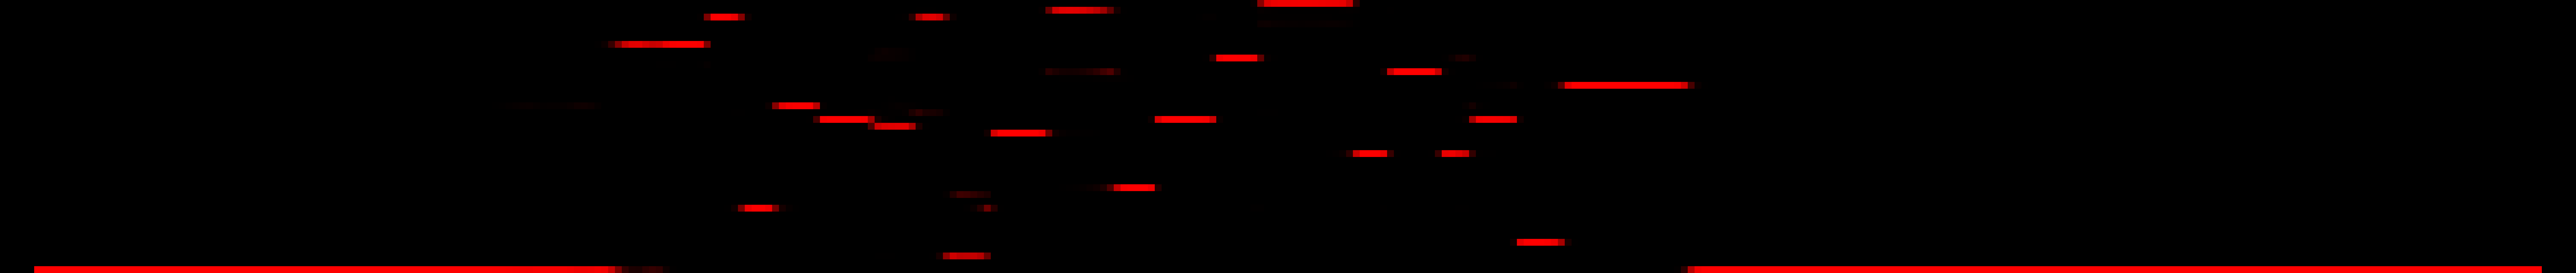

In [49]:
representation = 'mel'
ppgs.plot.from_ppg_file_to_file(
    promonet.CACHE_DIR / dataset / f'{stem}-100-{representation}-ppg.pt',
    f'{representation}.png')
ipd.Image(f'{representation}.png')

In [50]:
w2v2fb = torch.load(promonet.CACHE_DIR / dataset / f'{stem}-100-ppg.pt')
repr_ppg = torch.load(promonet.CACHE_DIR / dataset / f'{stem}-100-{representation}-ppg.pt')

In [51]:
w2v2fb.shape

torch.Size([40, 367])

In [52]:
repr_ppg.shape

torch.Size([40, 367])

## Training

In [142]:
directory = promonet.RUNS_DIR / promonet.CONFIG
adapt_from = None
gpu = 0

# Get torch device
device = torch.device('cpu' if gpu is None else f'cuda:{gpu}')

#######################
# Create data loaders #
#######################

torch.manual_seed(promonet.RANDOM_SEED)
train_loader = promonet.data.loader(dataset, 'train', gpu)
valid_loader = promonet.data.loader(dataset, 'valid', gpu)

#################
# Create models #
#################

generator = promonet.model.Generator().to(device)
discriminators = promonet.model.Discriminator().to(device)

#####################
# Create optimizers #
#####################

discriminator_optimizer = promonet.OPTIMIZER(discriminators.parameters())
generator_optimizer = promonet.OPTIMIZER(generator.parameters())

##############################
# Maybe load from checkpoint #
##############################

generator_path = torchutil.checkpoint.latest_path(
    directory if adapt_from is None else adapt_from,
    'generator-*.pt')
discriminator_path = torchutil.checkpoint.latest_path(
    directory if adapt_from is None else adapt_from,
    'discriminator-*.pt')

if generator_path and discriminator_path:

    # Load generator
    (
        generator,
        generator_optimizer,
        state
    ) = torchutil.checkpoint.load(
        generator_path,
        generator,
        generator_optimizer
    )
    step, epoch = state['step'], state['epoch']

    # Load discriminator
    (
        discriminators,
        discriminator_optimizer,
        _
    ) = torchutil.checkpoint.load(
        discriminator_path,
        discriminators,
        discriminator_optimizer
    )

else:

    # Train from scratch
    step, epoch = 0, 0


# Get total number of steps
if adapt_from:
    steps = promonet.STEPS + promonet.ADAPTATION_STEPS
else:
    steps = promonet.STEPS

# Automatic mixed precision (amp) gradient scaler
scaler = torch.cuda.amp.GradScaler()

# Setup progress bar
progress = torchutil.iterator(
    range(step, steps),
    f'{"Train" if adapt_from is None else "Adapt"}ing {promonet.CONFIG}',
    initial=step,
    total=steps)

RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "synthesizer.prior_encoder.input_layer.weight", "synthesizer.prior_encoder.input_layer.bias", "synthesizer.prior_encoder.encoder.attn_layers.0.emb_rel_k", "synthesizer.prior_encoder.encoder.attn_layers.0.emb_rel_v", "synthesizer.prior_encoder.encoder.attn_layers.0.conv_q.weight", "synthesizer.prior_encoder.encoder.attn_layers.0.conv_q.bias", "synthesizer.prior_encoder.encoder.attn_layers.0.conv_k.weight", "synthesizer.prior_encoder.encoder.attn_layers.0.conv_k.bias", "synthesizer.prior_encoder.encoder.attn_layers.0.conv_v.weight", "synthesizer.prior_encoder.encoder.attn_layers.0.conv_v.bias", "synthesizer.prior_encoder.encoder.attn_layers.0.conv_o.weight", "synthesizer.prior_encoder.encoder.attn_layers.0.conv_o.bias", "synthesizer.prior_encoder.encoder.attn_layers.1.emb_rel_k", "synthesizer.prior_encoder.encoder.attn_layers.1.emb_rel_v", "synthesizer.prior_encoder.encoder.attn_layers.1.conv_q.weight", "synthesizer.prior_encoder.encoder.attn_layers.1.conv_q.bias", "synthesizer.prior_encoder.encoder.attn_layers.1.conv_k.weight", "synthesizer.prior_encoder.encoder.attn_layers.1.conv_k.bias", "synthesizer.prior_encoder.encoder.attn_layers.1.conv_v.weight", "synthesizer.prior_encoder.encoder.attn_layers.1.conv_v.bias", "synthesizer.prior_encoder.encoder.attn_layers.1.conv_o.weight", "synthesizer.prior_encoder.encoder.attn_layers.1.conv_o.bias", "synthesizer.prior_encoder.encoder.attn_layers.2.emb_rel_k", "synthesizer.prior_encoder.encoder.attn_layers.2.emb_rel_v", "synthesizer.prior_encoder.encoder.attn_layers.2.conv_q.weight", "synthesizer.prior_encoder.encoder.attn_layers.2.conv_q.bias", "synthesizer.prior_encoder.encoder.attn_layers.2.conv_k.weight", "synthesizer.prior_encoder.encoder.attn_layers.2.conv_k.bias", "synthesizer.prior_encoder.encoder.attn_layers.2.conv_v.weight", "synthesizer.prior_encoder.encoder.attn_layers.2.conv_v.bias", "synthesizer.prior_encoder.encoder.attn_layers.2.conv_o.weight", "synthesizer.prior_encoder.encoder.attn_layers.2.conv_o.bias", "synthesizer.prior_encoder.encoder.attn_layers.3.emb_rel_k", "synthesizer.prior_encoder.encoder.attn_layers.3.emb_rel_v", "synthesizer.prior_encoder.encoder.attn_layers.3.conv_q.weight", "synthesizer.prior_encoder.encoder.attn_layers.3.conv_q.bias", "synthesizer.prior_encoder.encoder.attn_layers.3.conv_k.weight", "synthesizer.prior_encoder.encoder.attn_layers.3.conv_k.bias", "synthesizer.prior_encoder.encoder.attn_layers.3.conv_v.weight", "synthesizer.prior_encoder.encoder.attn_layers.3.conv_v.bias", "synthesizer.prior_encoder.encoder.attn_layers.3.conv_o.weight", "synthesizer.prior_encoder.encoder.attn_layers.3.conv_o.bias", "synthesizer.prior_encoder.encoder.attn_layers.4.emb_rel_k", "synthesizer.prior_encoder.encoder.attn_layers.4.emb_rel_v", "synthesizer.prior_encoder.encoder.attn_layers.4.conv_q.weight", "synthesizer.prior_encoder.encoder.attn_layers.4.conv_q.bias", "synthesizer.prior_encoder.encoder.attn_layers.4.conv_k.weight", "synthesizer.prior_encoder.encoder.attn_layers.4.conv_k.bias", "synthesizer.prior_encoder.encoder.attn_layers.4.conv_v.weight", "synthesizer.prior_encoder.encoder.attn_layers.4.conv_v.bias", "synthesizer.prior_encoder.encoder.attn_layers.4.conv_o.weight", "synthesizer.prior_encoder.encoder.attn_layers.4.conv_o.bias", "synthesizer.prior_encoder.encoder.attn_layers.5.emb_rel_k", "synthesizer.prior_encoder.encoder.attn_layers.5.emb_rel_v", "synthesizer.prior_encoder.encoder.attn_layers.5.conv_q.weight", "synthesizer.prior_encoder.encoder.attn_layers.5.conv_q.bias", "synthesizer.prior_encoder.encoder.attn_layers.5.conv_k.weight", "synthesizer.prior_encoder.encoder.attn_layers.5.conv_k.bias", "synthesizer.prior_encoder.encoder.attn_layers.5.conv_v.weight", "synthesizer.prior_encoder.encoder.attn_layers.5.conv_v.bias", "synthesizer.prior_encoder.encoder.attn_layers.5.conv_o.weight", "synthesizer.prior_encoder.encoder.attn_layers.5.conv_o.bias", "synthesizer.prior_encoder.encoder.norm_layers_1.0.gamma", "synthesizer.prior_encoder.encoder.norm_layers_1.0.beta", "synthesizer.prior_encoder.encoder.norm_layers_1.1.gamma", "synthesizer.prior_encoder.encoder.norm_layers_1.1.beta", "synthesizer.prior_encoder.encoder.norm_layers_1.2.gamma", "synthesizer.prior_encoder.encoder.norm_layers_1.2.beta", "synthesizer.prior_encoder.encoder.norm_layers_1.3.gamma", "synthesizer.prior_encoder.encoder.norm_layers_1.3.beta", "synthesizer.prior_encoder.encoder.norm_layers_1.4.gamma", "synthesizer.prior_encoder.encoder.norm_layers_1.4.beta", "synthesizer.prior_encoder.encoder.norm_layers_1.5.gamma", "synthesizer.prior_encoder.encoder.norm_layers_1.5.beta", "synthesizer.prior_encoder.encoder.ffn_layers.0.conv_1.weight", "synthesizer.prior_encoder.encoder.ffn_layers.0.conv_1.bias", "synthesizer.prior_encoder.encoder.ffn_layers.0.conv_2.weight", "synthesizer.prior_encoder.encoder.ffn_layers.0.conv_2.bias", "synthesizer.prior_encoder.encoder.ffn_layers.1.conv_1.weight", "synthesizer.prior_encoder.encoder.ffn_layers.1.conv_1.bias", "synthesizer.prior_encoder.encoder.ffn_layers.1.conv_2.weight", "synthesizer.prior_encoder.encoder.ffn_layers.1.conv_2.bias", "synthesizer.prior_encoder.encoder.ffn_layers.2.conv_1.weight", "synthesizer.prior_encoder.encoder.ffn_layers.2.conv_1.bias", "synthesizer.prior_encoder.encoder.ffn_layers.2.conv_2.weight", "synthesizer.prior_encoder.encoder.ffn_layers.2.conv_2.bias", "synthesizer.prior_encoder.encoder.ffn_layers.3.conv_1.weight", "synthesizer.prior_encoder.encoder.ffn_layers.3.conv_1.bias", "synthesizer.prior_encoder.encoder.ffn_layers.3.conv_2.weight", "synthesizer.prior_encoder.encoder.ffn_layers.3.conv_2.bias", "synthesizer.prior_encoder.encoder.ffn_layers.4.conv_1.weight", "synthesizer.prior_encoder.encoder.ffn_layers.4.conv_1.bias", "synthesizer.prior_encoder.encoder.ffn_layers.4.conv_2.weight", "synthesizer.prior_encoder.encoder.ffn_layers.4.conv_2.bias", "synthesizer.prior_encoder.encoder.ffn_layers.5.conv_1.weight", "synthesizer.prior_encoder.encoder.ffn_layers.5.conv_1.bias", "synthesizer.prior_encoder.encoder.ffn_layers.5.conv_2.weight", "synthesizer.prior_encoder.encoder.ffn_layers.5.conv_2.bias", "synthesizer.prior_encoder.encoder.norm_layers_2.0.gamma", "synthesizer.prior_encoder.encoder.norm_layers_2.0.beta", "synthesizer.prior_encoder.encoder.norm_layers_2.1.gamma", "synthesizer.prior_encoder.encoder.norm_layers_2.1.beta", "synthesizer.prior_encoder.encoder.norm_layers_2.2.gamma", "synthesizer.prior_encoder.encoder.norm_layers_2.2.beta", "synthesizer.prior_encoder.encoder.norm_layers_2.3.gamma", "synthesizer.prior_encoder.encoder.norm_layers_2.3.beta", "synthesizer.prior_encoder.encoder.norm_layers_2.4.gamma", "synthesizer.prior_encoder.encoder.norm_layers_2.4.beta", "synthesizer.prior_encoder.encoder.norm_layers_2.5.gamma", "synthesizer.prior_encoder.encoder.norm_layers_2.5.beta", "synthesizer.prior_encoder.projection.weight", "synthesizer.prior_encoder.projection.bias", "synthesizer.prior_encoder.cond.weight", "synthesizer.prior_encoder.cond.bias", "synthesizer.posterior_encoder.pre.weight", "synthesizer.posterior_encoder.pre.bias", "synthesizer.posterior_encoder.enc.in_layers.0.bias", "synthesizer.posterior_encoder.enc.in_layers.0.weight_g", "synthesizer.posterior_encoder.enc.in_layers.0.weight_v", "synthesizer.posterior_encoder.enc.in_layers.1.bias", "synthesizer.posterior_encoder.enc.in_layers.1.weight_g", "synthesizer.posterior_encoder.enc.in_layers.1.weight_v", "synthesizer.posterior_encoder.enc.in_layers.2.bias", "synthesizer.posterior_encoder.enc.in_layers.2.weight_g", "synthesizer.posterior_encoder.enc.in_layers.2.weight_v", "synthesizer.posterior_encoder.enc.in_layers.3.bias", "synthesizer.posterior_encoder.enc.in_layers.3.weight_g", "synthesizer.posterior_encoder.enc.in_layers.3.weight_v", "synthesizer.posterior_encoder.enc.in_layers.4.bias", "synthesizer.posterior_encoder.enc.in_layers.4.weight_g", "synthesizer.posterior_encoder.enc.in_layers.4.weight_v", "synthesizer.posterior_encoder.enc.in_layers.5.bias", "synthesizer.posterior_encoder.enc.in_layers.5.weight_g", "synthesizer.posterior_encoder.enc.in_layers.5.weight_v", "synthesizer.posterior_encoder.enc.in_layers.6.bias", "synthesizer.posterior_encoder.enc.in_layers.6.weight_g", "synthesizer.posterior_encoder.enc.in_layers.6.weight_v", "synthesizer.posterior_encoder.enc.in_layers.7.bias", "synthesizer.posterior_encoder.enc.in_layers.7.weight_g", "synthesizer.posterior_encoder.enc.in_layers.7.weight_v", "synthesizer.posterior_encoder.enc.in_layers.8.bias", "synthesizer.posterior_encoder.enc.in_layers.8.weight_g", "synthesizer.posterior_encoder.enc.in_layers.8.weight_v", "synthesizer.posterior_encoder.enc.in_layers.9.bias", "synthesizer.posterior_encoder.enc.in_layers.9.weight_g", "synthesizer.posterior_encoder.enc.in_layers.9.weight_v", "synthesizer.posterior_encoder.enc.in_layers.10.bias", "synthesizer.posterior_encoder.enc.in_layers.10.weight_g", "synthesizer.posterior_encoder.enc.in_layers.10.weight_v", "synthesizer.posterior_encoder.enc.in_layers.11.bias", "synthesizer.posterior_encoder.enc.in_layers.11.weight_g", "synthesizer.posterior_encoder.enc.in_layers.11.weight_v", "synthesizer.posterior_encoder.enc.in_layers.12.bias", "synthesizer.posterior_encoder.enc.in_layers.12.weight_g", "synthesizer.posterior_encoder.enc.in_layers.12.weight_v", "synthesizer.posterior_encoder.enc.in_layers.13.bias", "synthesizer.posterior_encoder.enc.in_layers.13.weight_g", "synthesizer.posterior_encoder.enc.in_layers.13.weight_v", "synthesizer.posterior_encoder.enc.in_layers.14.bias", "synthesizer.posterior_encoder.enc.in_layers.14.weight_g", "synthesizer.posterior_encoder.enc.in_layers.14.weight_v", "synthesizer.posterior_encoder.enc.in_layers.15.bias", "synthesizer.posterior_encoder.enc.in_layers.15.weight_g", "synthesizer.posterior_encoder.enc.in_layers.15.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.0.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.0.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.0.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.1.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.1.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.1.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.2.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.2.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.2.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.3.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.3.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.3.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.4.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.4.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.4.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.5.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.5.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.5.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.6.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.6.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.6.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.7.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.7.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.7.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.8.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.8.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.8.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.9.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.9.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.9.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.10.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.10.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.10.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.11.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.11.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.11.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.12.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.12.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.12.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.13.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.13.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.13.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.14.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.14.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.14.weight_v", "synthesizer.posterior_encoder.enc.res_skip_layers.15.bias", "synthesizer.posterior_encoder.enc.res_skip_layers.15.weight_g", "synthesizer.posterior_encoder.enc.res_skip_layers.15.weight_v", "synthesizer.posterior_encoder.enc.cond_layer.bias", "synthesizer.posterior_encoder.enc.cond_layer.weight_g", "synthesizer.posterior_encoder.enc.cond_layer.weight_v", "synthesizer.posterior_encoder.proj.weight", "synthesizer.posterior_encoder.proj.bias", "synthesizer.flow.flows.0.pre.weight", "synthesizer.flow.flows.0.pre.bias", "synthesizer.flow.flows.0.enc.in_layers.0.bias", "synthesizer.flow.flows.0.enc.in_layers.0.weight_g", "synthesizer.flow.flows.0.enc.in_layers.0.weight_v", "synthesizer.flow.flows.0.enc.in_layers.1.bias", "synthesizer.flow.flows.0.enc.in_layers.1.weight_g", "synthesizer.flow.flows.0.enc.in_layers.1.weight_v", "synthesizer.flow.flows.0.enc.in_layers.2.bias", "synthesizer.flow.flows.0.enc.in_layers.2.weight_g", "synthesizer.flow.flows.0.enc.in_layers.2.weight_v", "synthesizer.flow.flows.0.enc.in_layers.3.bias", "synthesizer.flow.flows.0.enc.in_layers.3.weight_g", "synthesizer.flow.flows.0.enc.in_layers.3.weight_v", "synthesizer.flow.flows.0.enc.res_skip_layers.0.bias", "synthesizer.flow.flows.0.enc.res_skip_layers.0.weight_g", "synthesizer.flow.flows.0.enc.res_skip_layers.0.weight_v", "synthesizer.flow.flows.0.enc.res_skip_layers.1.bias", "synthesizer.flow.flows.0.enc.res_skip_layers.1.weight_g", "synthesizer.flow.flows.0.enc.res_skip_layers.1.weight_v", "synthesizer.flow.flows.0.enc.res_skip_layers.2.bias", "synthesizer.flow.flows.0.enc.res_skip_layers.2.weight_g", "synthesizer.flow.flows.0.enc.res_skip_layers.2.weight_v", "synthesizer.flow.flows.0.enc.res_skip_layers.3.bias", "synthesizer.flow.flows.0.enc.res_skip_layers.3.weight_g", "synthesizer.flow.flows.0.enc.res_skip_layers.3.weight_v", "synthesizer.flow.flows.0.enc.cond_layer.bias", "synthesizer.flow.flows.0.enc.cond_layer.weight_g", "synthesizer.flow.flows.0.enc.cond_layer.weight_v", "synthesizer.flow.flows.0.post.weight", "synthesizer.flow.flows.0.post.bias", "synthesizer.flow.flows.2.pre.weight", "synthesizer.flow.flows.2.pre.bias", "synthesizer.flow.flows.2.enc.in_layers.0.bias", "synthesizer.flow.flows.2.enc.in_layers.0.weight_g", "synthesizer.flow.flows.2.enc.in_layers.0.weight_v", "synthesizer.flow.flows.2.enc.in_layers.1.bias", "synthesizer.flow.flows.2.enc.in_layers.1.weight_g", "synthesizer.flow.flows.2.enc.in_layers.1.weight_v", "synthesizer.flow.flows.2.enc.in_layers.2.bias", "synthesizer.flow.flows.2.enc.in_layers.2.weight_g", "synthesizer.flow.flows.2.enc.in_layers.2.weight_v", "synthesizer.flow.flows.2.enc.in_layers.3.bias", "synthesizer.flow.flows.2.enc.in_layers.3.weight_g", "synthesizer.flow.flows.2.enc.in_layers.3.weight_v", "synthesizer.flow.flows.2.enc.res_skip_layers.0.bias", "synthesizer.flow.flows.2.enc.res_skip_layers.0.weight_g", "synthesizer.flow.flows.2.enc.res_skip_layers.0.weight_v", "synthesizer.flow.flows.2.enc.res_skip_layers.1.bias", "synthesizer.flow.flows.2.enc.res_skip_layers.1.weight_g", "synthesizer.flow.flows.2.enc.res_skip_layers.1.weight_v", "synthesizer.flow.flows.2.enc.res_skip_layers.2.bias", "synthesizer.flow.flows.2.enc.res_skip_layers.2.weight_g", "synthesizer.flow.flows.2.enc.res_skip_layers.2.weight_v", "synthesizer.flow.flows.2.enc.res_skip_layers.3.bias", "synthesizer.flow.flows.2.enc.res_skip_layers.3.weight_g", "synthesizer.flow.flows.2.enc.res_skip_layers.3.weight_v", "synthesizer.flow.flows.2.enc.cond_layer.bias", "synthesizer.flow.flows.2.enc.cond_layer.weight_g", "synthesizer.flow.flows.2.enc.cond_layer.weight_v", "synthesizer.flow.flows.2.post.weight", "synthesizer.flow.flows.2.post.bias", "synthesizer.flow.flows.4.pre.weight", "synthesizer.flow.flows.4.pre.bias", "synthesizer.flow.flows.4.enc.in_layers.0.bias", "synthesizer.flow.flows.4.enc.in_layers.0.weight_g", "synthesizer.flow.flows.4.enc.in_layers.0.weight_v", "synthesizer.flow.flows.4.enc.in_layers.1.bias", "synthesizer.flow.flows.4.enc.in_layers.1.weight_g", "synthesizer.flow.flows.4.enc.in_layers.1.weight_v", "synthesizer.flow.flows.4.enc.in_layers.2.bias", "synthesizer.flow.flows.4.enc.in_layers.2.weight_g", "synthesizer.flow.flows.4.enc.in_layers.2.weight_v", "synthesizer.flow.flows.4.enc.in_layers.3.bias", "synthesizer.flow.flows.4.enc.in_layers.3.weight_g", "synthesizer.flow.flows.4.enc.in_layers.3.weight_v", "synthesizer.flow.flows.4.enc.res_skip_layers.0.bias", "synthesizer.flow.flows.4.enc.res_skip_layers.0.weight_g", "synthesizer.flow.flows.4.enc.res_skip_layers.0.weight_v", "synthesizer.flow.flows.4.enc.res_skip_layers.1.bias", "synthesizer.flow.flows.4.enc.res_skip_layers.1.weight_g", "synthesizer.flow.flows.4.enc.res_skip_layers.1.weight_v", "synthesizer.flow.flows.4.enc.res_skip_layers.2.bias", "synthesizer.flow.flows.4.enc.res_skip_layers.2.weight_g", "synthesizer.flow.flows.4.enc.res_skip_layers.2.weight_v", "synthesizer.flow.flows.4.enc.res_skip_layers.3.bias", "synthesizer.flow.flows.4.enc.res_skip_layers.3.weight_g", "synthesizer.flow.flows.4.enc.res_skip_layers.3.weight_v", "synthesizer.flow.flows.4.enc.cond_layer.bias", "synthesizer.flow.flows.4.enc.cond_layer.weight_g", "synthesizer.flow.flows.4.enc.cond_layer.weight_v", "synthesizer.flow.flows.4.post.weight", "synthesizer.flow.flows.4.post.bias", "synthesizer.flow.flows.6.pre.weight", "synthesizer.flow.flows.6.pre.bias", "synthesizer.flow.flows.6.enc.in_layers.0.bias", "synthesizer.flow.flows.6.enc.in_layers.0.weight_g", "synthesizer.flow.flows.6.enc.in_layers.0.weight_v", "synthesizer.flow.flows.6.enc.in_layers.1.bias", "synthesizer.flow.flows.6.enc.in_layers.1.weight_g", "synthesizer.flow.flows.6.enc.in_layers.1.weight_v", "synthesizer.flow.flows.6.enc.in_layers.2.bias", "synthesizer.flow.flows.6.enc.in_layers.2.weight_g", "synthesizer.flow.flows.6.enc.in_layers.2.weight_v", "synthesizer.flow.flows.6.enc.in_layers.3.bias", "synthesizer.flow.flows.6.enc.in_layers.3.weight_g", "synthesizer.flow.flows.6.enc.in_layers.3.weight_v", "synthesizer.flow.flows.6.enc.res_skip_layers.0.bias", "synthesizer.flow.flows.6.enc.res_skip_layers.0.weight_g", "synthesizer.flow.flows.6.enc.res_skip_layers.0.weight_v", "synthesizer.flow.flows.6.enc.res_skip_layers.1.bias", "synthesizer.flow.flows.6.enc.res_skip_layers.1.weight_g", "synthesizer.flow.flows.6.enc.res_skip_layers.1.weight_v", "synthesizer.flow.flows.6.enc.res_skip_layers.2.bias", "synthesizer.flow.flows.6.enc.res_skip_layers.2.weight_g", "synthesizer.flow.flows.6.enc.res_skip_layers.2.weight_v", "synthesizer.flow.flows.6.enc.res_skip_layers.3.bias", "synthesizer.flow.flows.6.enc.res_skip_layers.3.weight_g", "synthesizer.flow.flows.6.enc.res_skip_layers.3.weight_v", "synthesizer.flow.flows.6.enc.cond_layer.bias", "synthesizer.flow.flows.6.enc.cond_layer.weight_g", "synthesizer.flow.flows.6.enc.cond_layer.weight_v", "synthesizer.flow.flows.6.post.weight", "synthesizer.flow.flows.6.post.bias". 
	Unexpected key(s) in state_dict: "prior_encoder.input_layer.weight", "prior_encoder.input_layer.bias", "prior_encoder.encoder.attn_layers.0.emb_rel_k", "prior_encoder.encoder.attn_layers.0.emb_rel_v", "prior_encoder.encoder.attn_layers.0.conv_q.weight", "prior_encoder.encoder.attn_layers.0.conv_q.bias", "prior_encoder.encoder.attn_layers.0.conv_k.weight", "prior_encoder.encoder.attn_layers.0.conv_k.bias", "prior_encoder.encoder.attn_layers.0.conv_v.weight", "prior_encoder.encoder.attn_layers.0.conv_v.bias", "prior_encoder.encoder.attn_layers.0.conv_o.weight", "prior_encoder.encoder.attn_layers.0.conv_o.bias", "prior_encoder.encoder.attn_layers.1.emb_rel_k", "prior_encoder.encoder.attn_layers.1.emb_rel_v", "prior_encoder.encoder.attn_layers.1.conv_q.weight", "prior_encoder.encoder.attn_layers.1.conv_q.bias", "prior_encoder.encoder.attn_layers.1.conv_k.weight", "prior_encoder.encoder.attn_layers.1.conv_k.bias", "prior_encoder.encoder.attn_layers.1.conv_v.weight", "prior_encoder.encoder.attn_layers.1.conv_v.bias", "prior_encoder.encoder.attn_layers.1.conv_o.weight", "prior_encoder.encoder.attn_layers.1.conv_o.bias", "prior_encoder.encoder.attn_layers.2.emb_rel_k", "prior_encoder.encoder.attn_layers.2.emb_rel_v", "prior_encoder.encoder.attn_layers.2.conv_q.weight", "prior_encoder.encoder.attn_layers.2.conv_q.bias", "prior_encoder.encoder.attn_layers.2.conv_k.weight", "prior_encoder.encoder.attn_layers.2.conv_k.bias", "prior_encoder.encoder.attn_layers.2.conv_v.weight", "prior_encoder.encoder.attn_layers.2.conv_v.bias", "prior_encoder.encoder.attn_layers.2.conv_o.weight", "prior_encoder.encoder.attn_layers.2.conv_o.bias", "prior_encoder.encoder.attn_layers.3.emb_rel_k", "prior_encoder.encoder.attn_layers.3.emb_rel_v", "prior_encoder.encoder.attn_layers.3.conv_q.weight", "prior_encoder.encoder.attn_layers.3.conv_q.bias", "prior_encoder.encoder.attn_layers.3.conv_k.weight", "prior_encoder.encoder.attn_layers.3.conv_k.bias", "prior_encoder.encoder.attn_layers.3.conv_v.weight", "prior_encoder.encoder.attn_layers.3.conv_v.bias", "prior_encoder.encoder.attn_layers.3.conv_o.weight", "prior_encoder.encoder.attn_layers.3.conv_o.bias", "prior_encoder.encoder.attn_layers.4.emb_rel_k", "prior_encoder.encoder.attn_layers.4.emb_rel_v", "prior_encoder.encoder.attn_layers.4.conv_q.weight", "prior_encoder.encoder.attn_layers.4.conv_q.bias", "prior_encoder.encoder.attn_layers.4.conv_k.weight", "prior_encoder.encoder.attn_layers.4.conv_k.bias", "prior_encoder.encoder.attn_layers.4.conv_v.weight", "prior_encoder.encoder.attn_layers.4.conv_v.bias", "prior_encoder.encoder.attn_layers.4.conv_o.weight", "prior_encoder.encoder.attn_layers.4.conv_o.bias", "prior_encoder.encoder.attn_layers.5.emb_rel_k", "prior_encoder.encoder.attn_layers.5.emb_rel_v", "prior_encoder.encoder.attn_layers.5.conv_q.weight", "prior_encoder.encoder.attn_layers.5.conv_q.bias", "prior_encoder.encoder.attn_layers.5.conv_k.weight", "prior_encoder.encoder.attn_layers.5.conv_k.bias", "prior_encoder.encoder.attn_layers.5.conv_v.weight", "prior_encoder.encoder.attn_layers.5.conv_v.bias", "prior_encoder.encoder.attn_layers.5.conv_o.weight", "prior_encoder.encoder.attn_layers.5.conv_o.bias", "prior_encoder.encoder.norm_layers_1.0.gamma", "prior_encoder.encoder.norm_layers_1.0.beta", "prior_encoder.encoder.norm_layers_1.1.gamma", "prior_encoder.encoder.norm_layers_1.1.beta", "prior_encoder.encoder.norm_layers_1.2.gamma", "prior_encoder.encoder.norm_layers_1.2.beta", "prior_encoder.encoder.norm_layers_1.3.gamma", "prior_encoder.encoder.norm_layers_1.3.beta", "prior_encoder.encoder.norm_layers_1.4.gamma", "prior_encoder.encoder.norm_layers_1.4.beta", "prior_encoder.encoder.norm_layers_1.5.gamma", "prior_encoder.encoder.norm_layers_1.5.beta", "prior_encoder.encoder.ffn_layers.0.conv_1.weight", "prior_encoder.encoder.ffn_layers.0.conv_1.bias", "prior_encoder.encoder.ffn_layers.0.conv_2.weight", "prior_encoder.encoder.ffn_layers.0.conv_2.bias", "prior_encoder.encoder.ffn_layers.1.conv_1.weight", "prior_encoder.encoder.ffn_layers.1.conv_1.bias", "prior_encoder.encoder.ffn_layers.1.conv_2.weight", "prior_encoder.encoder.ffn_layers.1.conv_2.bias", "prior_encoder.encoder.ffn_layers.2.conv_1.weight", "prior_encoder.encoder.ffn_layers.2.conv_1.bias", "prior_encoder.encoder.ffn_layers.2.conv_2.weight", "prior_encoder.encoder.ffn_layers.2.conv_2.bias", "prior_encoder.encoder.ffn_layers.3.conv_1.weight", "prior_encoder.encoder.ffn_layers.3.conv_1.bias", "prior_encoder.encoder.ffn_layers.3.conv_2.weight", "prior_encoder.encoder.ffn_layers.3.conv_2.bias", "prior_encoder.encoder.ffn_layers.4.conv_1.weight", "prior_encoder.encoder.ffn_layers.4.conv_1.bias", "prior_encoder.encoder.ffn_layers.4.conv_2.weight", "prior_encoder.encoder.ffn_layers.4.conv_2.bias", "prior_encoder.encoder.ffn_layers.5.conv_1.weight", "prior_encoder.encoder.ffn_layers.5.conv_1.bias", "prior_encoder.encoder.ffn_layers.5.conv_2.weight", "prior_encoder.encoder.ffn_layers.5.conv_2.bias", "prior_encoder.encoder.norm_layers_2.0.gamma", "prior_encoder.encoder.norm_layers_2.0.beta", "prior_encoder.encoder.norm_layers_2.1.gamma", "prior_encoder.encoder.norm_layers_2.1.beta", "prior_encoder.encoder.norm_layers_2.2.gamma", "prior_encoder.encoder.norm_layers_2.2.beta", "prior_encoder.encoder.norm_layers_2.3.gamma", "prior_encoder.encoder.norm_layers_2.3.beta", "prior_encoder.encoder.norm_layers_2.4.gamma", "prior_encoder.encoder.norm_layers_2.4.beta", "prior_encoder.encoder.norm_layers_2.5.gamma", "prior_encoder.encoder.norm_layers_2.5.beta", "prior_encoder.projection.weight", "prior_encoder.projection.bias", "prior_encoder.cond.weight", "prior_encoder.cond.bias", "posterior_encoder.pre.weight", "posterior_encoder.pre.bias", "posterior_encoder.enc.in_layers.0.bias", "posterior_encoder.enc.in_layers.0.weight_g", "posterior_encoder.enc.in_layers.0.weight_v", "posterior_encoder.enc.in_layers.1.bias", "posterior_encoder.enc.in_layers.1.weight_g", "posterior_encoder.enc.in_layers.1.weight_v", "posterior_encoder.enc.in_layers.2.bias", "posterior_encoder.enc.in_layers.2.weight_g", "posterior_encoder.enc.in_layers.2.weight_v", "posterior_encoder.enc.in_layers.3.bias", "posterior_encoder.enc.in_layers.3.weight_g", "posterior_encoder.enc.in_layers.3.weight_v", "posterior_encoder.enc.in_layers.4.bias", "posterior_encoder.enc.in_layers.4.weight_g", "posterior_encoder.enc.in_layers.4.weight_v", "posterior_encoder.enc.in_layers.5.bias", "posterior_encoder.enc.in_layers.5.weight_g", "posterior_encoder.enc.in_layers.5.weight_v", "posterior_encoder.enc.in_layers.6.bias", "posterior_encoder.enc.in_layers.6.weight_g", "posterior_encoder.enc.in_layers.6.weight_v", "posterior_encoder.enc.in_layers.7.bias", "posterior_encoder.enc.in_layers.7.weight_g", "posterior_encoder.enc.in_layers.7.weight_v", "posterior_encoder.enc.in_layers.8.bias", "posterior_encoder.enc.in_layers.8.weight_g", "posterior_encoder.enc.in_layers.8.weight_v", "posterior_encoder.enc.in_layers.9.bias", "posterior_encoder.enc.in_layers.9.weight_g", "posterior_encoder.enc.in_layers.9.weight_v", "posterior_encoder.enc.in_layers.10.bias", "posterior_encoder.enc.in_layers.10.weight_g", "posterior_encoder.enc.in_layers.10.weight_v", "posterior_encoder.enc.in_layers.11.bias", "posterior_encoder.enc.in_layers.11.weight_g", "posterior_encoder.enc.in_layers.11.weight_v", "posterior_encoder.enc.in_layers.12.bias", "posterior_encoder.enc.in_layers.12.weight_g", "posterior_encoder.enc.in_layers.12.weight_v", "posterior_encoder.enc.in_layers.13.bias", "posterior_encoder.enc.in_layers.13.weight_g", "posterior_encoder.enc.in_layers.13.weight_v", "posterior_encoder.enc.in_layers.14.bias", "posterior_encoder.enc.in_layers.14.weight_g", "posterior_encoder.enc.in_layers.14.weight_v", "posterior_encoder.enc.in_layers.15.bias", "posterior_encoder.enc.in_layers.15.weight_g", "posterior_encoder.enc.in_layers.15.weight_v", "posterior_encoder.enc.res_skip_layers.0.bias", "posterior_encoder.enc.res_skip_layers.0.weight_g", "posterior_encoder.enc.res_skip_layers.0.weight_v", "posterior_encoder.enc.res_skip_layers.1.bias", "posterior_encoder.enc.res_skip_layers.1.weight_g", "posterior_encoder.enc.res_skip_layers.1.weight_v", "posterior_encoder.enc.res_skip_layers.2.bias", "posterior_encoder.enc.res_skip_layers.2.weight_g", "posterior_encoder.enc.res_skip_layers.2.weight_v", "posterior_encoder.enc.res_skip_layers.3.bias", "posterior_encoder.enc.res_skip_layers.3.weight_g", "posterior_encoder.enc.res_skip_layers.3.weight_v", "posterior_encoder.enc.res_skip_layers.4.bias", "posterior_encoder.enc.res_skip_layers.4.weight_g", "posterior_encoder.enc.res_skip_layers.4.weight_v", "posterior_encoder.enc.res_skip_layers.5.bias", "posterior_encoder.enc.res_skip_layers.5.weight_g", "posterior_encoder.enc.res_skip_layers.5.weight_v", "posterior_encoder.enc.res_skip_layers.6.bias", "posterior_encoder.enc.res_skip_layers.6.weight_g", "posterior_encoder.enc.res_skip_layers.6.weight_v", "posterior_encoder.enc.res_skip_layers.7.bias", "posterior_encoder.enc.res_skip_layers.7.weight_g", "posterior_encoder.enc.res_skip_layers.7.weight_v", "posterior_encoder.enc.res_skip_layers.8.bias", "posterior_encoder.enc.res_skip_layers.8.weight_g", "posterior_encoder.enc.res_skip_layers.8.weight_v", "posterior_encoder.enc.res_skip_layers.9.bias", "posterior_encoder.enc.res_skip_layers.9.weight_g", "posterior_encoder.enc.res_skip_layers.9.weight_v", "posterior_encoder.enc.res_skip_layers.10.bias", "posterior_encoder.enc.res_skip_layers.10.weight_g", "posterior_encoder.enc.res_skip_layers.10.weight_v", "posterior_encoder.enc.res_skip_layers.11.bias", "posterior_encoder.enc.res_skip_layers.11.weight_g", "posterior_encoder.enc.res_skip_layers.11.weight_v", "posterior_encoder.enc.res_skip_layers.12.bias", "posterior_encoder.enc.res_skip_layers.12.weight_g", "posterior_encoder.enc.res_skip_layers.12.weight_v", "posterior_encoder.enc.res_skip_layers.13.bias", "posterior_encoder.enc.res_skip_layers.13.weight_g", "posterior_encoder.enc.res_skip_layers.13.weight_v", "posterior_encoder.enc.res_skip_layers.14.bias", "posterior_encoder.enc.res_skip_layers.14.weight_g", "posterior_encoder.enc.res_skip_layers.14.weight_v", "posterior_encoder.enc.res_skip_layers.15.bias", "posterior_encoder.enc.res_skip_layers.15.weight_g", "posterior_encoder.enc.res_skip_layers.15.weight_v", "posterior_encoder.enc.cond_layer.bias", "posterior_encoder.enc.cond_layer.weight_g", "posterior_encoder.enc.cond_layer.weight_v", "posterior_encoder.proj.weight", "posterior_encoder.proj.bias", "flow.flows.0.pre.weight", "flow.flows.0.pre.bias", "flow.flows.0.enc.in_layers.0.bias", "flow.flows.0.enc.in_layers.0.weight_g", "flow.flows.0.enc.in_layers.0.weight_v", "flow.flows.0.enc.in_layers.1.bias", "flow.flows.0.enc.in_layers.1.weight_g", "flow.flows.0.enc.in_layers.1.weight_v", "flow.flows.0.enc.in_layers.2.bias", "flow.flows.0.enc.in_layers.2.weight_g", "flow.flows.0.enc.in_layers.2.weight_v", "flow.flows.0.enc.in_layers.3.bias", "flow.flows.0.enc.in_layers.3.weight_g", "flow.flows.0.enc.in_layers.3.weight_v", "flow.flows.0.enc.res_skip_layers.0.bias", "flow.flows.0.enc.res_skip_layers.0.weight_g", "flow.flows.0.enc.res_skip_layers.0.weight_v", "flow.flows.0.enc.res_skip_layers.1.bias", "flow.flows.0.enc.res_skip_layers.1.weight_g", "flow.flows.0.enc.res_skip_layers.1.weight_v", "flow.flows.0.enc.res_skip_layers.2.bias", "flow.flows.0.enc.res_skip_layers.2.weight_g", "flow.flows.0.enc.res_skip_layers.2.weight_v", "flow.flows.0.enc.res_skip_layers.3.bias", "flow.flows.0.enc.res_skip_layers.3.weight_g", "flow.flows.0.enc.res_skip_layers.3.weight_v", "flow.flows.0.enc.cond_layer.bias", "flow.flows.0.enc.cond_layer.weight_g", "flow.flows.0.enc.cond_layer.weight_v", "flow.flows.0.post.weight", "flow.flows.0.post.bias", "flow.flows.2.pre.weight", "flow.flows.2.pre.bias", "flow.flows.2.enc.in_layers.0.bias", "flow.flows.2.enc.in_layers.0.weight_g", "flow.flows.2.enc.in_layers.0.weight_v", "flow.flows.2.enc.in_layers.1.bias", "flow.flows.2.enc.in_layers.1.weight_g", "flow.flows.2.enc.in_layers.1.weight_v", "flow.flows.2.enc.in_layers.2.bias", "flow.flows.2.enc.in_layers.2.weight_g", "flow.flows.2.enc.in_layers.2.weight_v", "flow.flows.2.enc.in_layers.3.bias", "flow.flows.2.enc.in_layers.3.weight_g", "flow.flows.2.enc.in_layers.3.weight_v", "flow.flows.2.enc.res_skip_layers.0.bias", "flow.flows.2.enc.res_skip_layers.0.weight_g", "flow.flows.2.enc.res_skip_layers.0.weight_v", "flow.flows.2.enc.res_skip_layers.1.bias", "flow.flows.2.enc.res_skip_layers.1.weight_g", "flow.flows.2.enc.res_skip_layers.1.weight_v", "flow.flows.2.enc.res_skip_layers.2.bias", "flow.flows.2.enc.res_skip_layers.2.weight_g", "flow.flows.2.enc.res_skip_layers.2.weight_v", "flow.flows.2.enc.res_skip_layers.3.bias", "flow.flows.2.enc.res_skip_layers.3.weight_g", "flow.flows.2.enc.res_skip_layers.3.weight_v", "flow.flows.2.enc.cond_layer.bias", "flow.flows.2.enc.cond_layer.weight_g", "flow.flows.2.enc.cond_layer.weight_v", "flow.flows.2.post.weight", "flow.flows.2.post.bias", "flow.flows.4.pre.weight", "flow.flows.4.pre.bias", "flow.flows.4.enc.in_layers.0.bias", "flow.flows.4.enc.in_layers.0.weight_g", "flow.flows.4.enc.in_layers.0.weight_v", "flow.flows.4.enc.in_layers.1.bias", "flow.flows.4.enc.in_layers.1.weight_g", "flow.flows.4.enc.in_layers.1.weight_v", "flow.flows.4.enc.in_layers.2.bias", "flow.flows.4.enc.in_layers.2.weight_g", "flow.flows.4.enc.in_layers.2.weight_v", "flow.flows.4.enc.in_layers.3.bias", "flow.flows.4.enc.in_layers.3.weight_g", "flow.flows.4.enc.in_layers.3.weight_v", "flow.flows.4.enc.res_skip_layers.0.bias", "flow.flows.4.enc.res_skip_layers.0.weight_g", "flow.flows.4.enc.res_skip_layers.0.weight_v", "flow.flows.4.enc.res_skip_layers.1.bias", "flow.flows.4.enc.res_skip_layers.1.weight_g", "flow.flows.4.enc.res_skip_layers.1.weight_v", "flow.flows.4.enc.res_skip_layers.2.bias", "flow.flows.4.enc.res_skip_layers.2.weight_g", "flow.flows.4.enc.res_skip_layers.2.weight_v", "flow.flows.4.enc.res_skip_layers.3.bias", "flow.flows.4.enc.res_skip_layers.3.weight_g", "flow.flows.4.enc.res_skip_layers.3.weight_v", "flow.flows.4.enc.cond_layer.bias", "flow.flows.4.enc.cond_layer.weight_g", "flow.flows.4.enc.cond_layer.weight_v", "flow.flows.4.post.weight", "flow.flows.4.post.bias", "flow.flows.6.pre.weight", "flow.flows.6.pre.bias", "flow.flows.6.enc.in_layers.0.bias", "flow.flows.6.enc.in_layers.0.weight_g", "flow.flows.6.enc.in_layers.0.weight_v", "flow.flows.6.enc.in_layers.1.bias", "flow.flows.6.enc.in_layers.1.weight_g", "flow.flows.6.enc.in_layers.1.weight_v", "flow.flows.6.enc.in_layers.2.bias", "flow.flows.6.enc.in_layers.2.weight_g", "flow.flows.6.enc.in_layers.2.weight_v", "flow.flows.6.enc.in_layers.3.bias", "flow.flows.6.enc.in_layers.3.weight_g", "flow.flows.6.enc.in_layers.3.weight_v", "flow.flows.6.enc.res_skip_layers.0.bias", "flow.flows.6.enc.res_skip_layers.0.weight_g", "flow.flows.6.enc.res_skip_layers.0.weight_v", "flow.flows.6.enc.res_skip_layers.1.bias", "flow.flows.6.enc.res_skip_layers.1.weight_g", "flow.flows.6.enc.res_skip_layers.1.weight_v", "flow.flows.6.enc.res_skip_layers.2.bias", "flow.flows.6.enc.res_skip_layers.2.weight_g", "flow.flows.6.enc.res_skip_layers.2.weight_v", "flow.flows.6.enc.res_skip_layers.3.bias", "flow.flows.6.enc.res_skip_layers.3.weight_g", "flow.flows.6.enc.res_skip_layers.3.weight_v", "flow.flows.6.enc.cond_layer.bias", "flow.flows.6.enc.cond_layer.weight_g", "flow.flows.6.enc.cond_layer.weight_v", "flow.flows.6.post.weight", "flow.flows.6.post.bias". 

In [117]:
step

7500

In [118]:
# Seed sampler
train_loader.batch_sampler.set_epoch(epoch)

for batch in train_loader:
    break

In [100]:
# Unpack batch
(
    _,
    phonemes,
    pitch,
    periodicity,
    loudness,
    lengths,
    speakers,
    formant_ratios,
    loudness_ratios,
    spectrograms,
    audio,
    _
) = batch

# Skip examples that are too short
if audio.shape[-1] < promonet.CHUNK_SIZE:
    assert False

# Copy to device
(
    phonemes,
    pitch,
    periodicity,
    loudness,
    lengths,
    speakers,
    formant_ratios,
    loudness_ratios,
    spectrograms,
    audio
) = (
    item.to(device) for item in
    (
        phonemes,
        pitch,
        periodicity,
        loudness,
        lengths,
        speakers,
        formant_ratios,
        loudness_ratios,
        spectrograms,
        audio
    )
)


# Bundle training input
generator_input = (
    phonemes,
    pitch,
    periodicity,
    loudness,
    lengths,
    speakers,
    formant_ratios,
    loudness_ratios,
    spectrograms)

In [112]:
with torch.autocast(device.type):

    # Forward pass through generator
    generated, *vits_args = generator(*generator_input)
    if promonet.MODEL == 'vits':
        (
            slice_indices,
            prior,
            predicted_mean,
            predicted_logstd,
            true_logstd
        ) = vits_args[0][0]

        # Slice ground truth audio
        audio_slice = promonet.model.slice_segments(
            audio,
            slice_indices * promonet.HOPSIZE,
            promonet.CHUNK_SIZE)

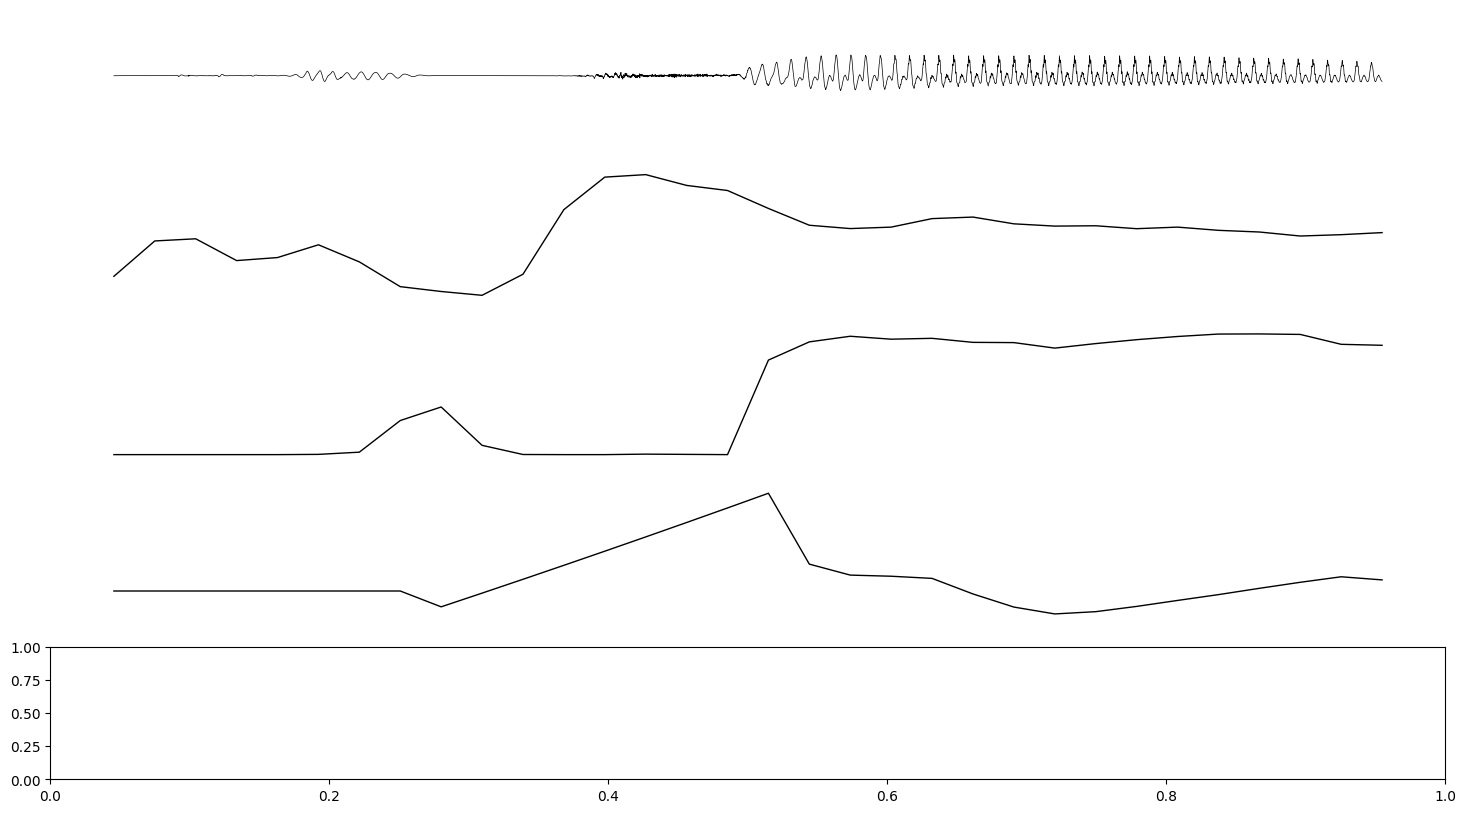

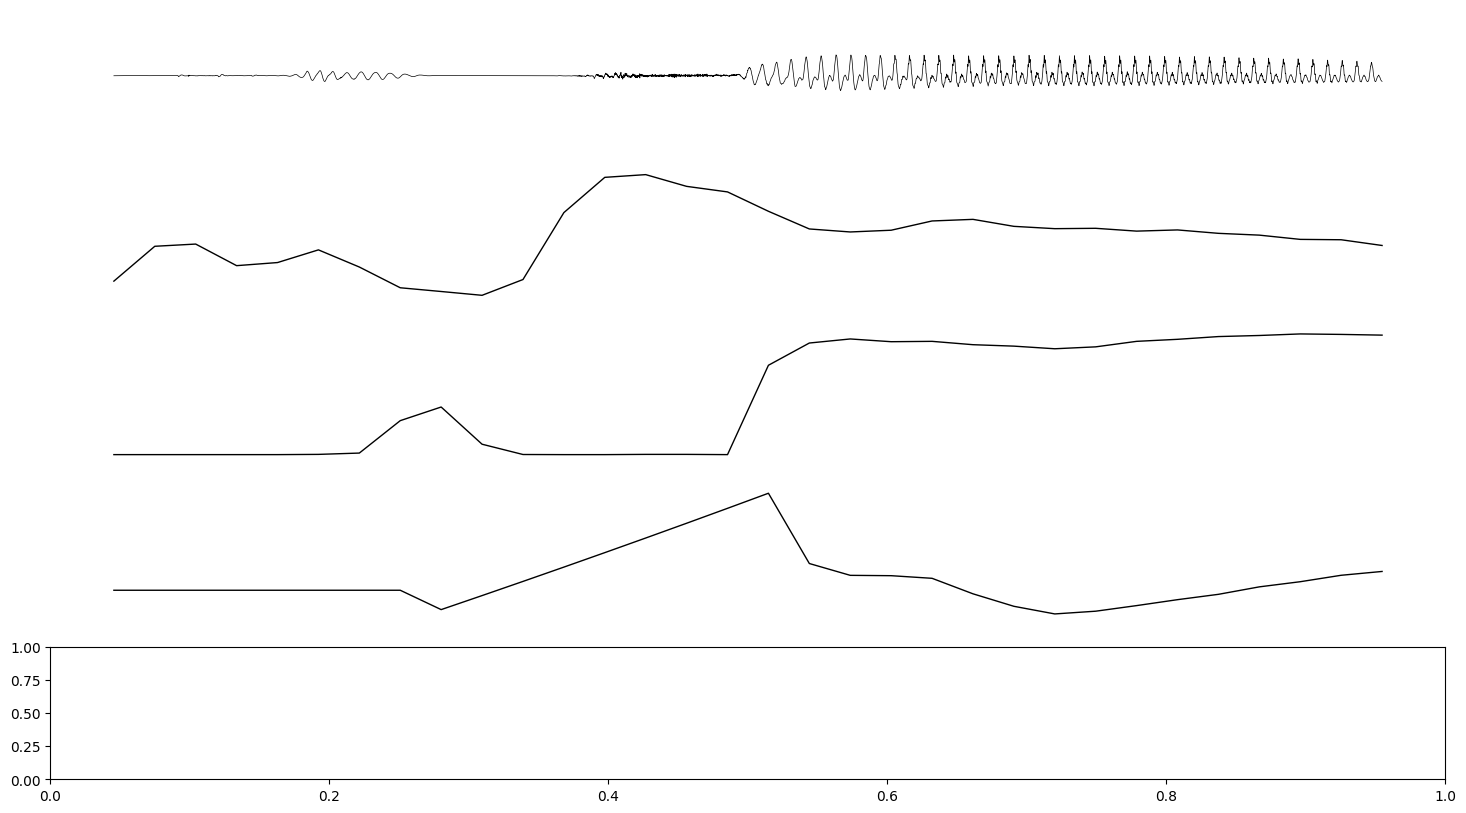

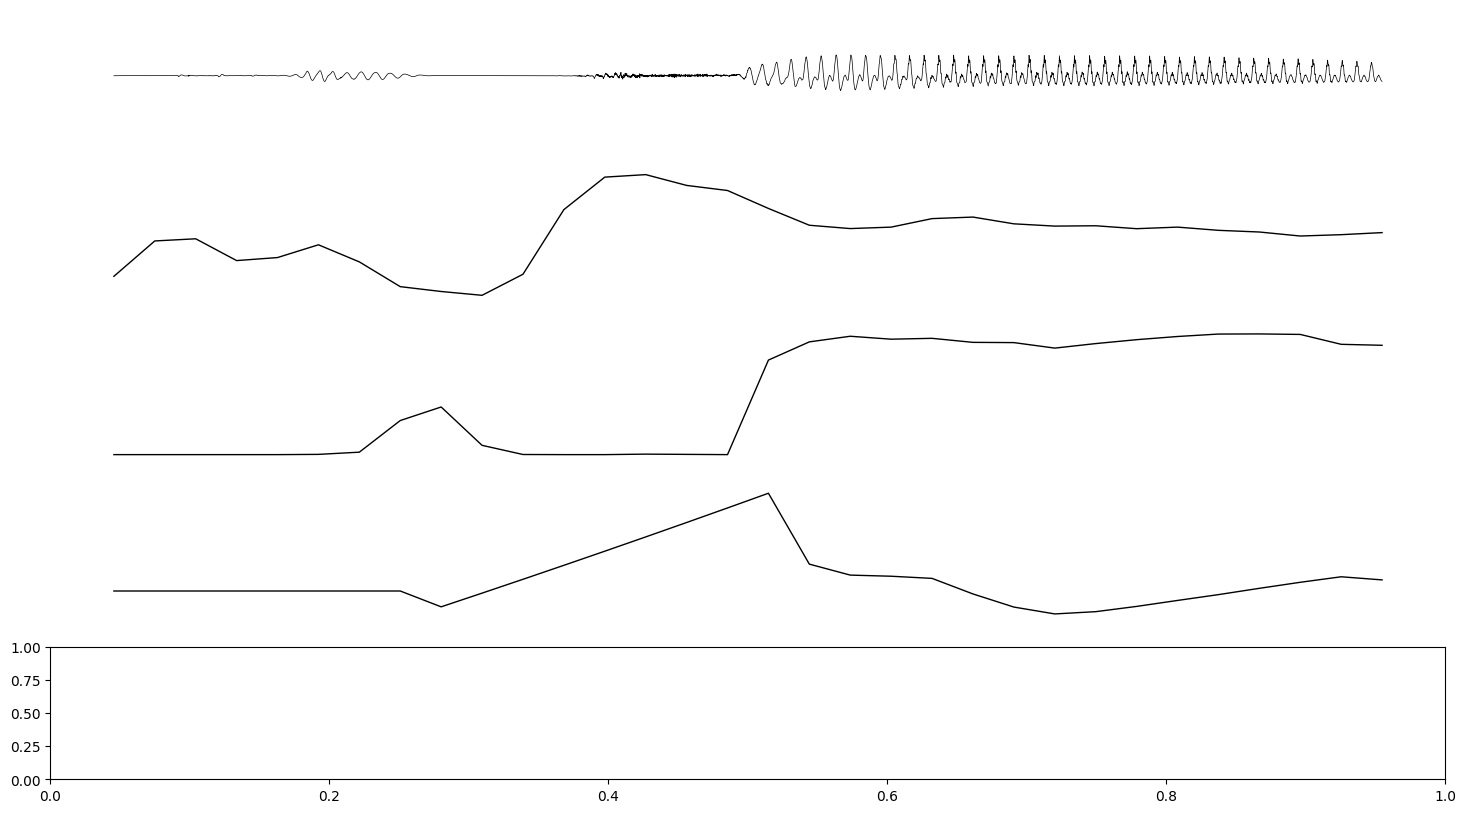

In [114]:
index = 10
chunk_size_frames = promonet.convert.samples_to_frames(promonet.CHUNK_SIZE)
promonet.plot.from_features(
    audio_slice[index],
    promonet.model.slice_segments(loudness, slice_indices, chunk_size_frames)[index],
    promonet.model.slice_segments(periodicity, slice_indices, chunk_size_frames)[index],
    promonet.model.slice_segments(pitch, slice_indices, chunk_size_frames)[index],
    promonet.model.slice_segments(phonemes, slice_indices, chunk_size_frames)[index])
promonet.plot.from_audio(audio_slice[index], gpu=0)

## Validation

In [120]:
# Setup evaluation metrics
metrics = {'reconstruction': promonet.evaluate.Metrics()}
ratios = [
    f'{int(ratio * 100):03d}' for ratio in promonet.EVALUATION_RATIOS]
if 'pitch' in promonet.INPUT_FEATURES:
    metrics.update({
        f'shifted-{ratio}': promonet.evaluate.Metrics()
        for ratio in ratios})
if 'ppg' in promonet.INPUT_FEATURES:
    metrics.update({
        f'stretched-{ratio}': promonet.evaluate.Metrics()
        for ratio in ratios})
if 'loudness' in promonet.INPUT_FEATURES:
    metrics.update({
        f'scaled-{ratio}': promonet.evaluate.Metrics()
        for ratio in ratios})

# Audio, figures, and scalars for tensorboard
waveforms, figures, scalars = {}, {}, {}

for i, batch in enumerate(valid_loader):
    break


In [121]:

# Unpack
(
    _,
    phonemes,
    pitch,
    periodicity,
    loudness,
    lengths,
    speakers,
    _,
    _,
    spectrogram,
    audio,
    _
) = batch

# Copy to device
(
    phonemes,
    pitch,
    periodicity,
    loudness,
    lengths,
    speakers,
    spectrogram,
    audio
) = (
    item.to(device) for item in (
        phonemes,
        pitch,
        periodicity,
        loudness,
        lengths,
        speakers,
        spectrogram,
        audio
    )
)

# Ensure audio and generated are same length
trim = audio.shape[-1] % promonet.HOPSIZE
if trim > 0:
    audio = audio[..., :-trim]

# Log original audio on first evaluation
if step == 0:
    waveforms[f'original/{i:02d}-audio'] = audio[0]


In [128]:
phonemes.shape

torch.Size([1, 40, 424])

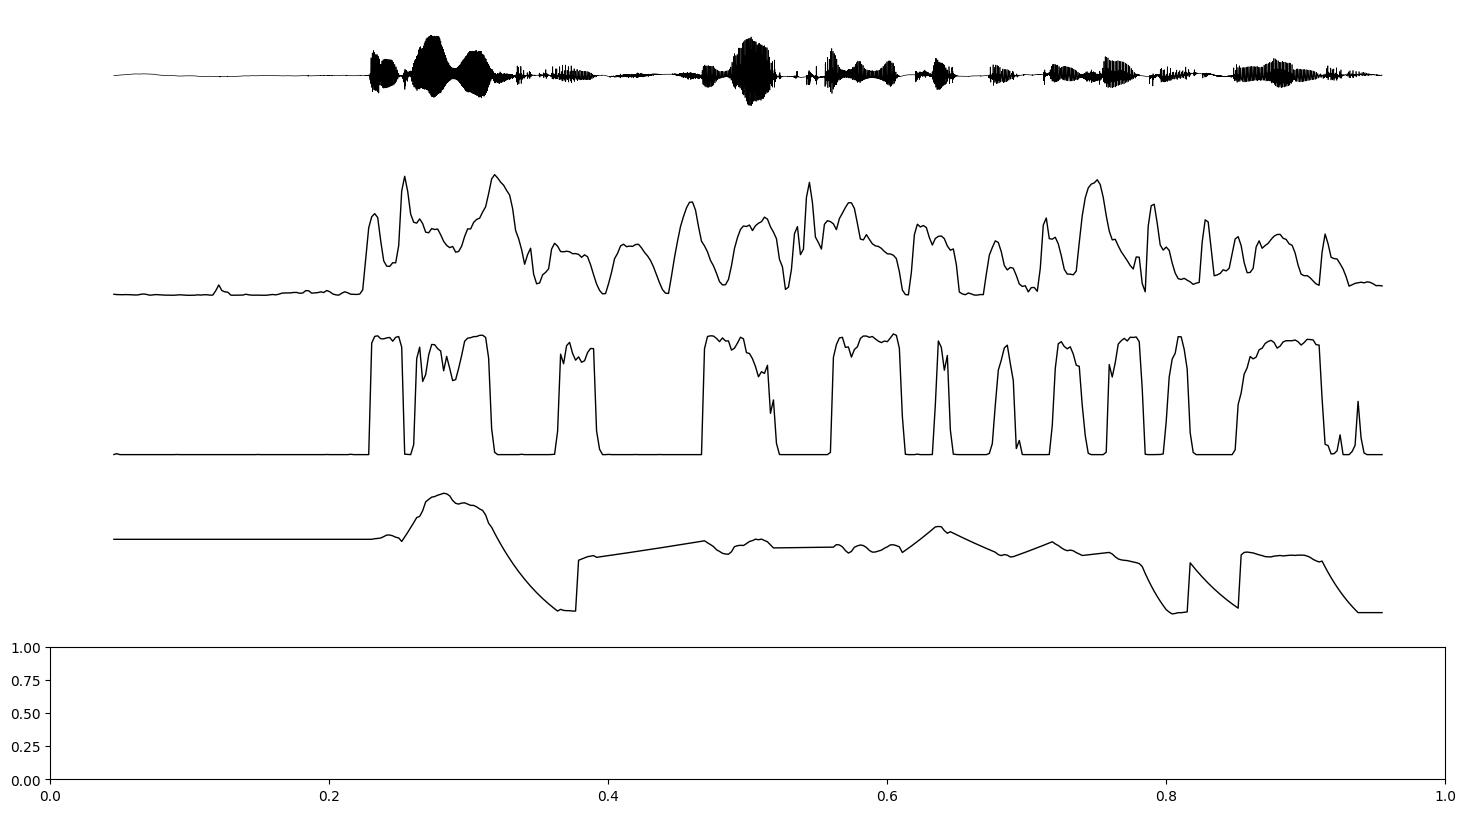

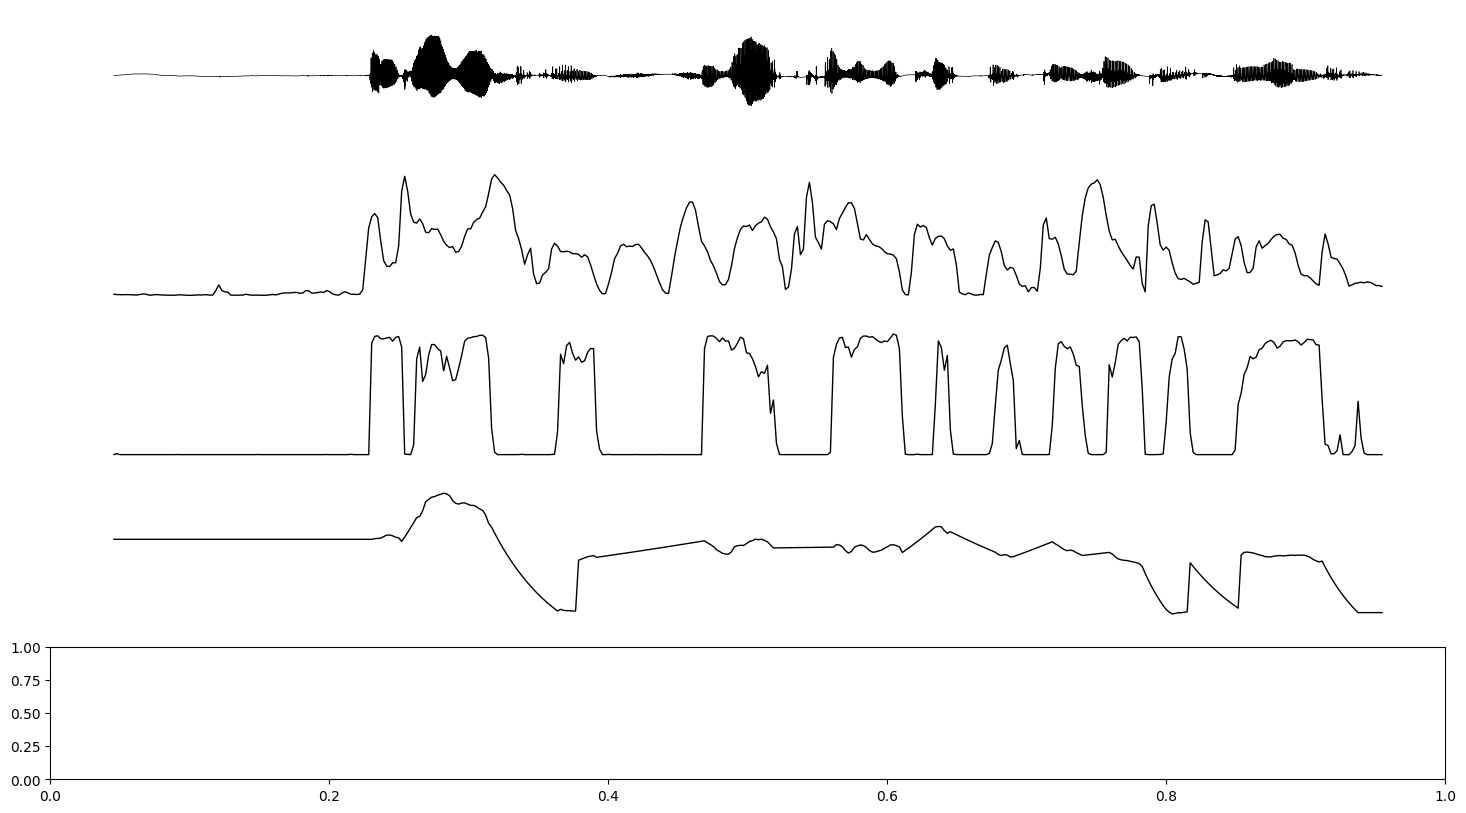

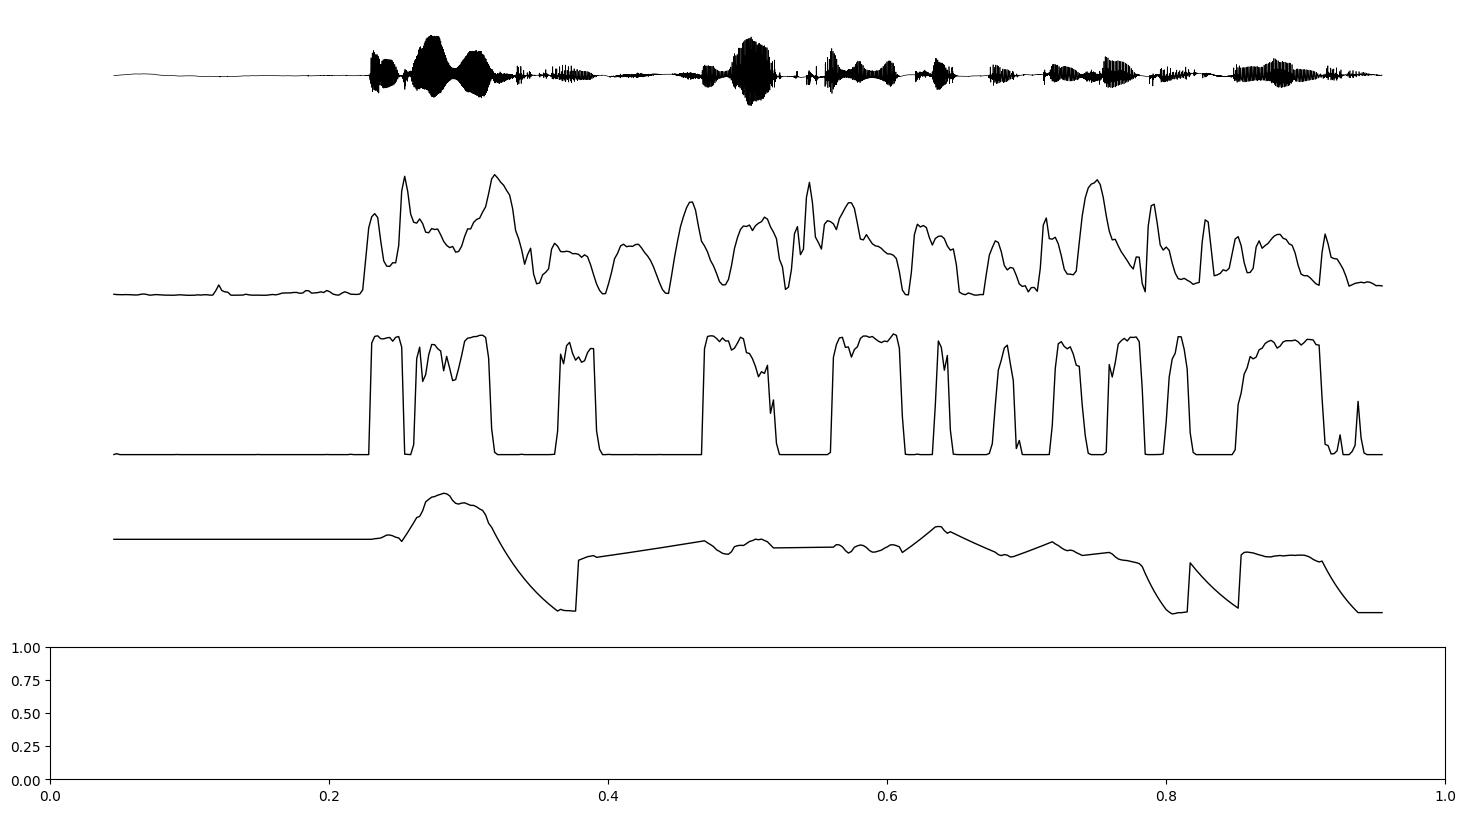

In [131]:
promonet.plot.from_features(
    audio[0],
    loudness,
    periodicity,
    pitch,
    phonemes[0])
promonet.plot.from_audio(audio[0], gpu=0)

In [136]:

##################
# Reconstruction #
##################

# Generate
with torchutil.inference.context(generator):
    generated, *_ = generator(
        phonemes,
        pitch,
        periodicity,
        loudness,
        lengths,
        speakers,
        spectrograms=spectrogram)


In [141]:
generated.shape

torch.Size([1, 1, 108544])

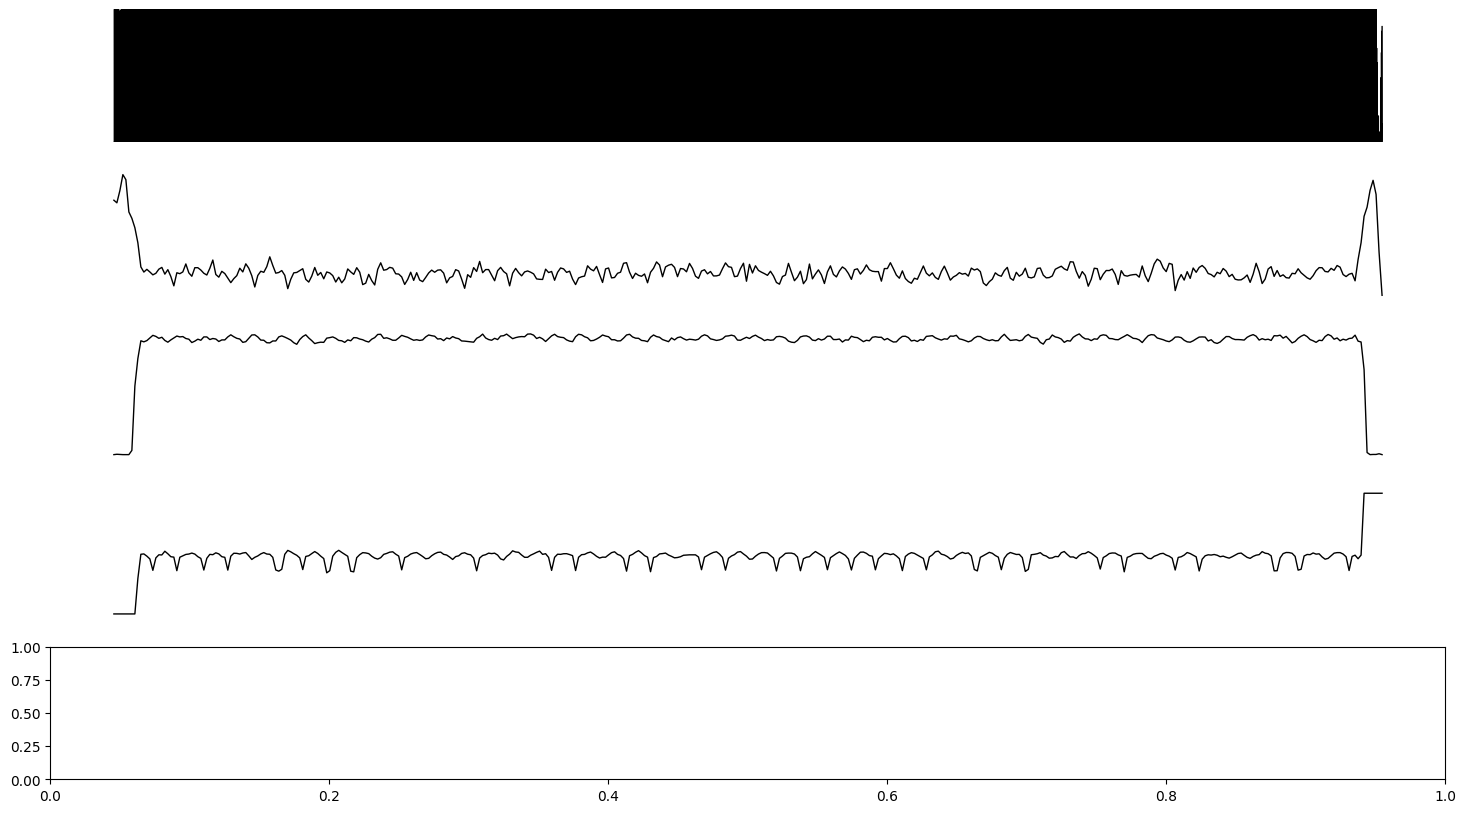

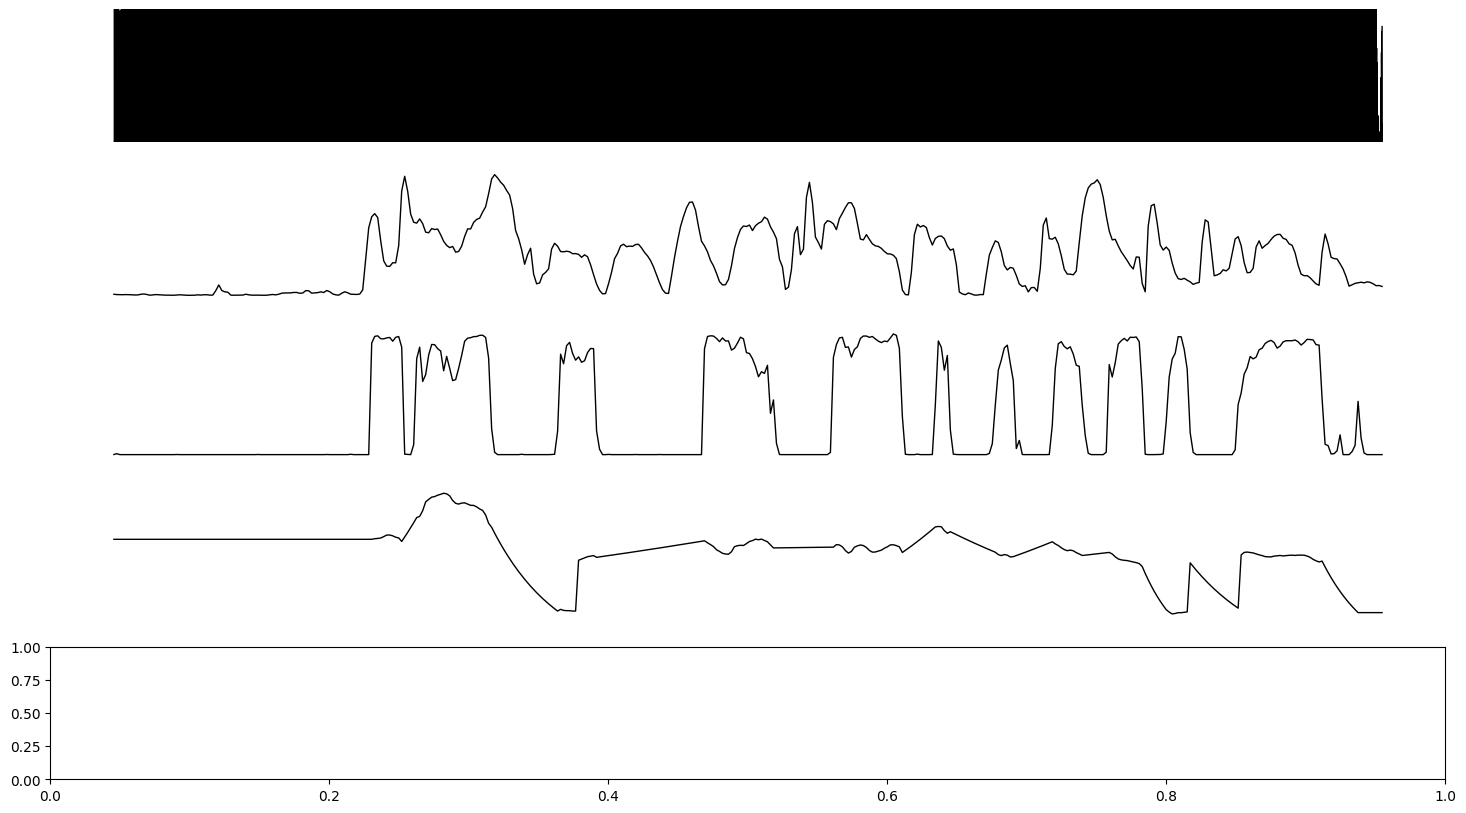

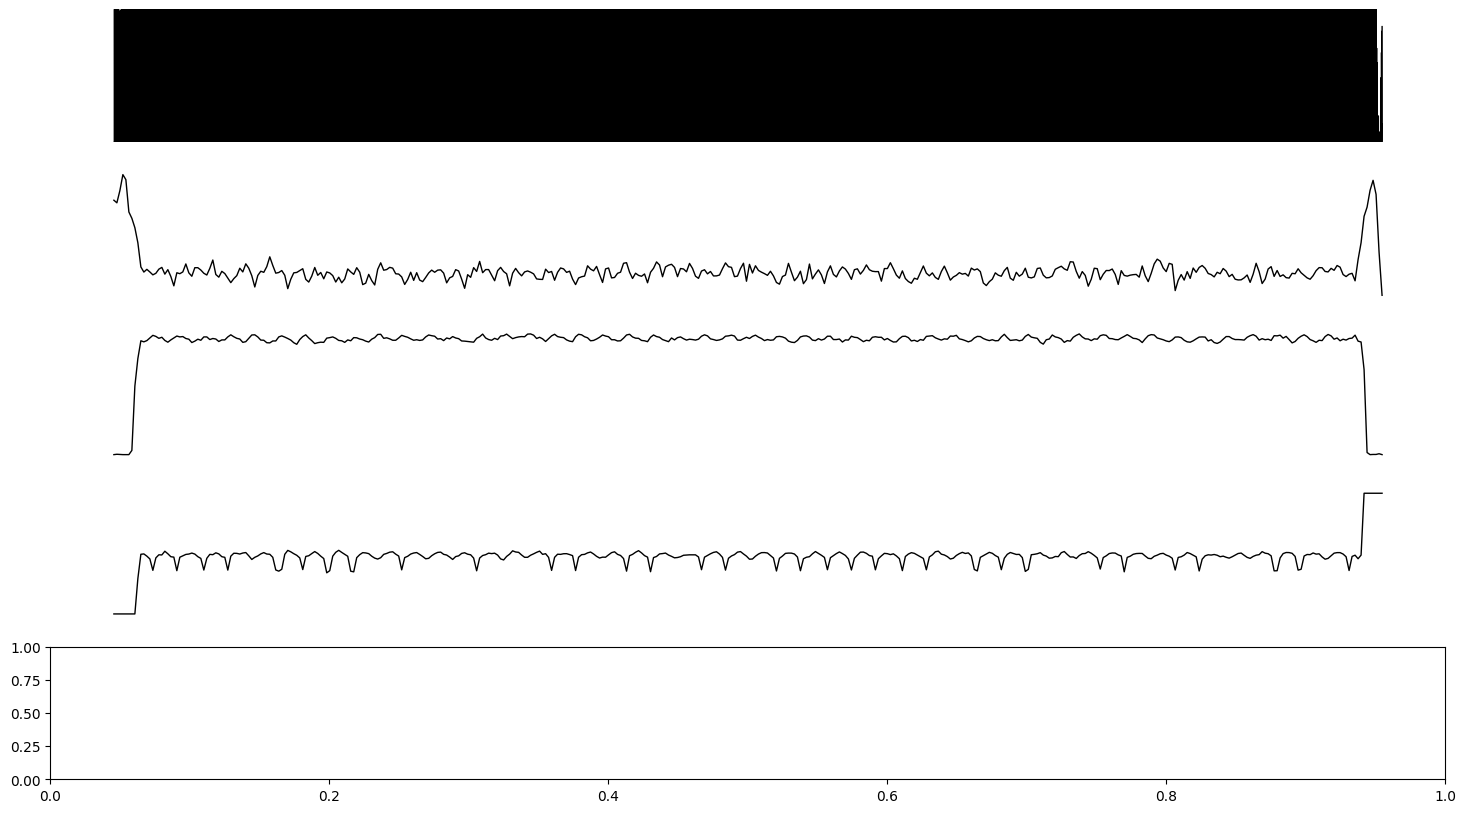

In [139]:
promonet.plot.from_features(
    generated[0].detach(),
    loudness,
    periodicity,
    pitch,
    phonemes[0])
promonet.plot.from_audio(generated[0].detach().to(torch.float32), gpu=0)

In [ ]:

# Log generated audio
key = f'reconstruction/{i:02d}'
waveforms[f'{key}-audio'] = generated[0]

# Get prosody features
(
    predicted_loudness,
    predicted_periodicity,
    predicted_pitch,
    predicted_phonemes
) = promonet.preprocess.from_audio(generated[0], gpu=gpu)

# Plot target and generated prosody
if i < promonet.PLOT_EXAMPLES:
    figures[key] = promonet.plot.from_features(
        generated,
        predicted_pitch,
        predicted_periodicity,
        predicted_loudness,
        predicted_phonemes,
        pitch,
        periodicity,
        loudness,
        phonemes)

# Update metrics
metrics[key.split('/')[0]].update(
    pitch,
    periodicity,
    loudness,
    phonemes,
    predicted_pitch,
    predicted_periodicity,
    predicted_loudness,
    predicted_phonemes)